In [11]:
from tsai.basics import *
import sktime
import sklearn
import get_processed_data as gpd
from tsai.models.InceptionTime import *
from tsai.models.utils import *

In [101]:
window_size = 15
overlap = 10

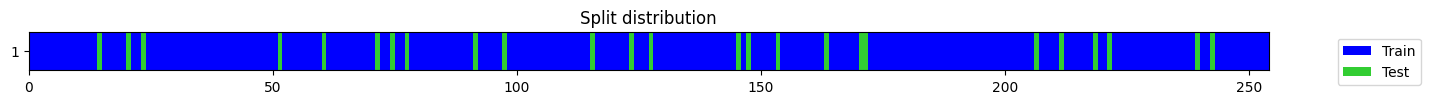

In [102]:
train, test = gpd.get_train_test_split("malte", window_size*60,overlap*60)

train_easy = train["easy"]
train_hard = train["hard"]

test_easy = test["easy"]
test_hard = test["hard"]

y_train_easy = np.full(len(train_easy), 'easy', dtype=object)
y_train_hard = np.full(len(train_hard), 'hard', dtype=object)
y_test_easy = np.full(len(test_easy), 'easy', dtype=object)
y_test_hard = np.full(len(test_hard), 'hard', dtype=object)

X = np.concatenate([train_easy, train_hard])
y = np.concatenate([y_train_easy, y_train_hard])

X = np.stack([np.transpose(np.array(x[['Quat_W', 'Quat_X', 'Quat_Y', 'Quat_Z', 'FreeAcc_X', 'FreeAcc_Y', 'FreeAcc_Z']].tolist()), (1, 0)) for x in X])

# create an array with two arrays inside for train and test. the train array contains the indices of the train samples and the test array the indices of the test samples
splits = get_splits(y, 1, 0.1, random_state=42, stratify=True, balance=True)

X_test = np.concatenate([test_easy, test_hard])
y_test = np.concatenate([y_test_easy, y_test_hard])
X_test = np.stack([np.transpose(np.array(x[['Quat_W', 'Quat_X', 'Quat_Y', 'Quat_Z', 'FreeAcc_X', 'FreeAcc_Y', 'FreeAcc_Z']].tolist()), (1, 0)) for x in X_test])


In [108]:
tfms = [None, TSClassification()]
batch_tfms = TSStandardize(by_sample=True)
dls = get_ts_dls(X, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms)
model = build_ts_model(InceptionTime, dls=dls)
learn = Learner(dls, model, metrics=accuracy, cbs=ShowGraph())

SuggestedLRs(valley=0.002511886414140463)

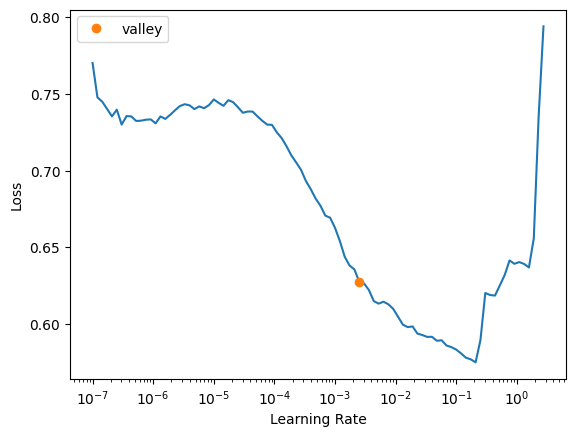

In [16]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,0.710439,0.716759,0.440000,00:00
1,0.706318,0.714947,0.440000,00:00
2,0.691223,0.714761,0.440000,00:00
3,0.674269,0.713066,0.360000,00:00
4,0.650176,0.704209,0.320000,00:00
5,0.618474,0.673281,0.520000,00:00
6,0.577862,0.581354,0.760000,00:00
7,0.530803,0.419988,0.960000,00:00
8,0.488371,0.280493,0.960000,00:00
9,0.445256,0.186774,0.960000,00:00


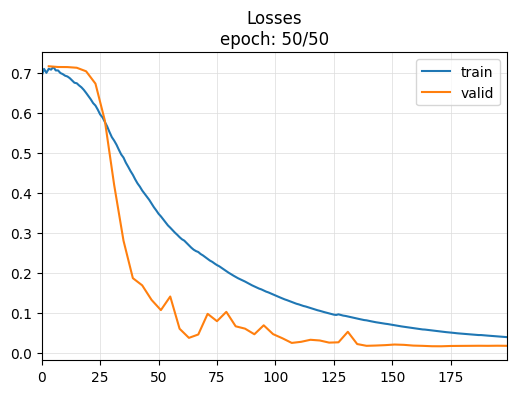

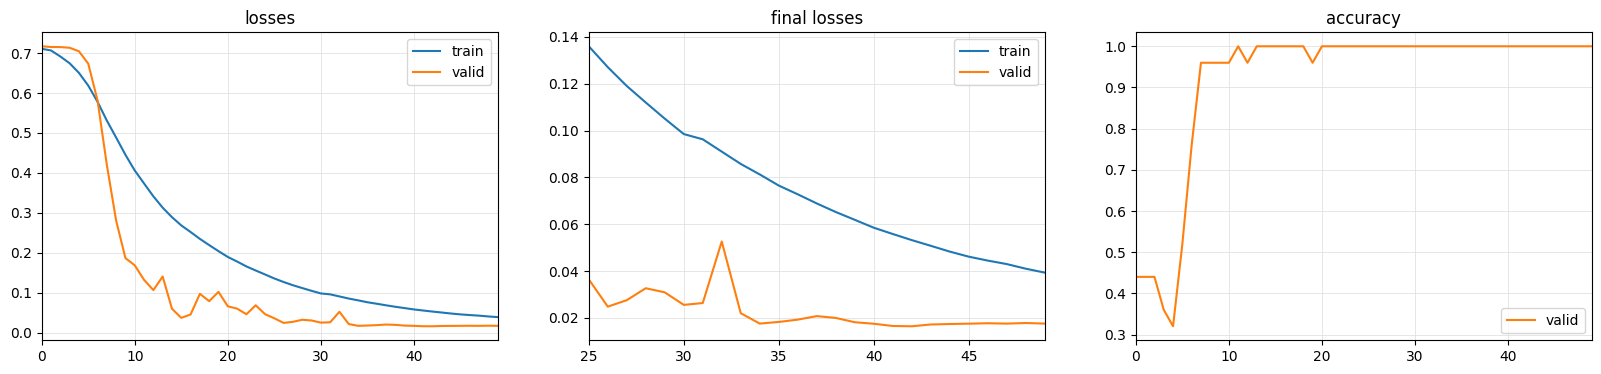

Total time              : 39.40322


39.40322

In [109]:
timer.start()
learn.fit_one_cycle(50, 2.2e-4)
timer.stop()

In [111]:
PATH = Path(f'./models/InceptionTime/InceptionTime{window_size}_{overlap}.pkl')
PATH.parent.mkdir(parents=True, exist_ok=True)
learn.export(PATH)

In [ ]:
del learn

In [109]:
PATH = Path(f'./models/InceptionTime/InceptionTime{window_size}_{overlap}.pkl')
learn = load_learner(PATH, cpu=False)

FileNotFoundError: [Errno 2] No such file or directory: 'models/XCM/XCM_10_5.pkl'

acc: 0.9666666666666667
balanced acc : 0.98
balanced acc (adjusted): 0.96
f1 score: 0.9678416821273963


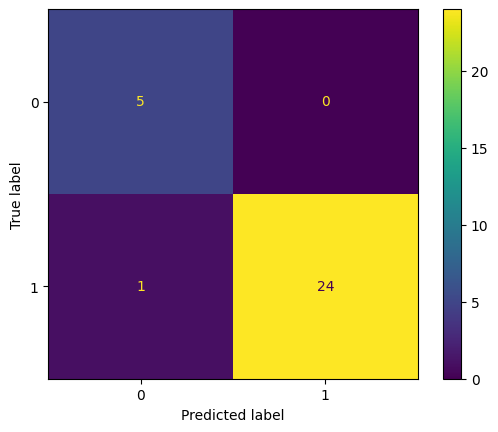

In [110]:
import sklearn.metrics


probas, _, preds = learn.get_X_preds(X_test)
print("acc:", sklearn.metrics.accuracy_score(y_test, preds))
print("balanced acc :", sklearn.metrics.balanced_accuracy_score(y_test, preds, adjusted=False))
print("balanced acc (adjusted):", sklearn.metrics.balanced_accuracy_score(y_test, preds, adjusted=True))
print("f1 score:", sklearn.metrics.f1_score(y_test, preds, average='weighted'))
conf = sklearn.metrics.ConfusionMatrixDisplay(sklearn.metrics.confusion_matrix(y_test, preds))
conf.plot()